<a href="https://colab.research.google.com/github/ndow33/DS-Unit-2-Kaggle-Challenge/blob/master/module1-decision-trees/LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [56]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [58]:
# Check Pandas Profiling version
import pandas_profiling
pandas_profiling.__version__

'2.5.0'

In [59]:
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Do train/validate/test split with the Tanzania Waterpumps data.

In [61]:
train.shape, test.shape

((59400, 41), (14358, 40))

In [62]:
#make a validation dataset that's the same length as the test dataset
validate = train.tail(14358)
validate.shape

(14358, 41)

In [63]:
#make the training data set exclude the validation data
difference = 59400-14358
train = train.head(difference)
train.shape

(45042, 41)

# Begin with baselines for classification

In [64]:
#find out what the most common status is 
train['status_group'].value_counts(normalize = True)

functional                 0.542893
non functional             0.384086
functional needs repair    0.073021
Name: status_group, dtype: float64

#Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.

In [65]:
#select features
target = 'status_group'

#get a dataframe with all train columns except the target and id
train_features = train.drop(columns = [target, 'id'])

#Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

#get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude = 'number').nunique()

#get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

#combine the lists
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
#Arrange data into x features matrix and y target vector
X_train = train[features]
y_train = train[target]
X_val = validate[features]
y_val = validate[target]
X_test = test[features]

In [0]:
#imports
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [0]:
#import and instantiate the pipeline
from sklearn.pipeline import make_pipeline

#import and instantiate the decision tree
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names = True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42)
)

pipeline.fit(X_train, y_train);


# Get your validation accuracy score.

In [69]:
print(f'Train accuracy: {pipeline.score(X_train, y_train)}')
print(f'Validation accuracy: {pipeline.score(X_val, y_val)}')

Train accuracy: 0.99527108032503
Validation accuracy: 0.7569995821145006


#Improve the validation accuracy

In [79]:
#limit the leaves 
pipeline2 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42, min_samples_leaf = 12)
)

pipeline2.fit(X_train, y_train)
print(f'Train accuracy: {pipeline2.score(X_train, y_train)}')
print(f'Validation accuracy: {pipeline2.score(X_val, y_val)}')



Train accuracy: 0.8292926601838284
Validation accuracy: 0.7700236801782978


# Get and plot your feature importances.

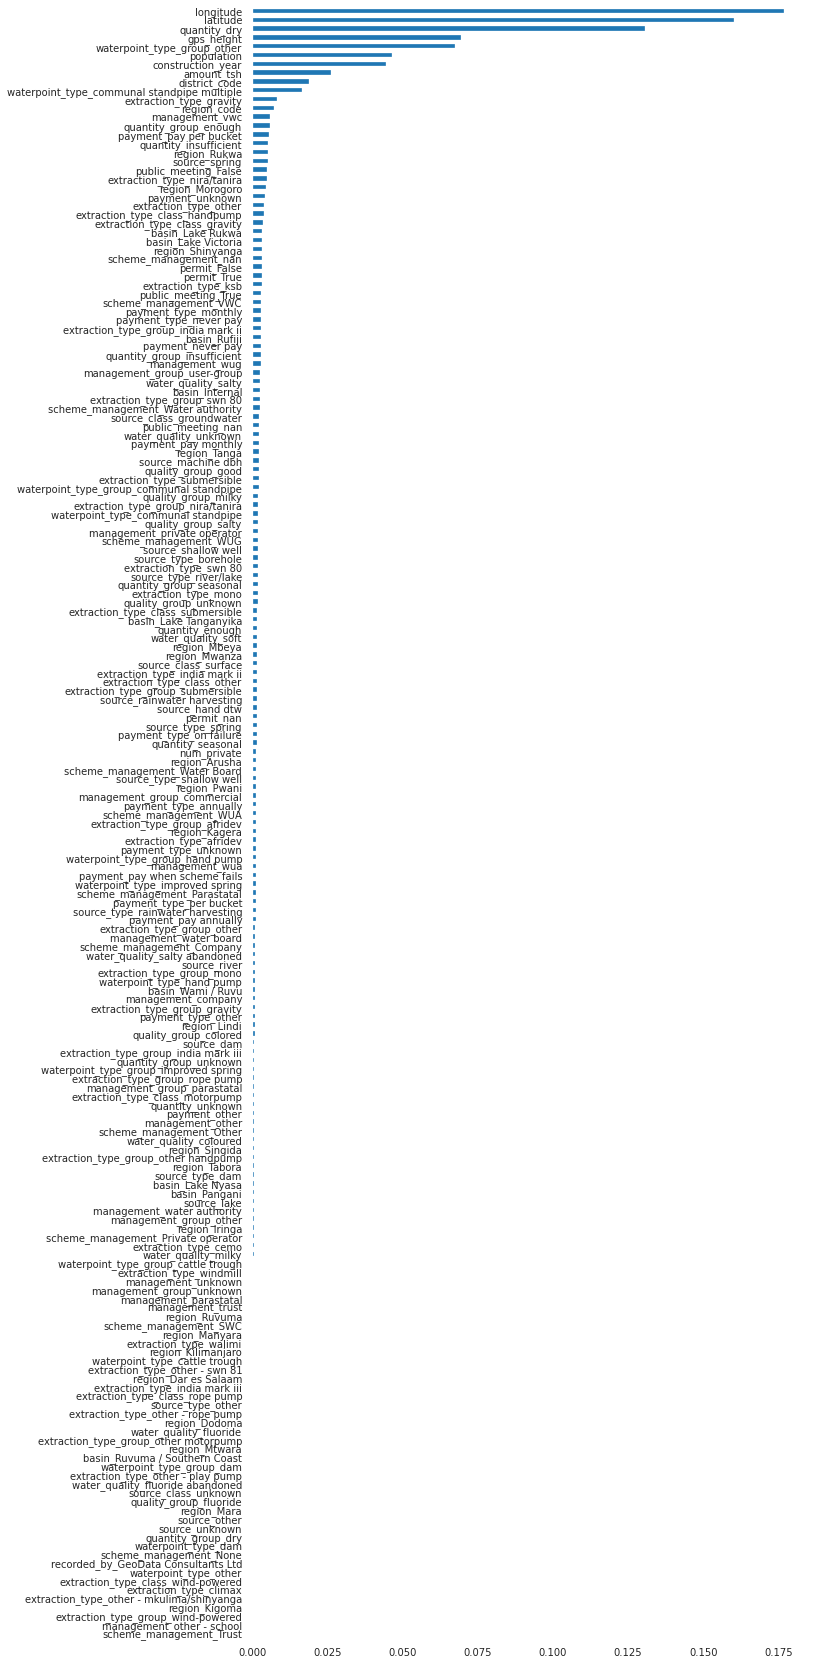

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize = (10,30))
importances.sort_values().plot.barh();

#Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue Submit Predictions button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)

In [0]:
# estimator is your model or pipeline, which you've fit on X_train

# X_test is your pandas dataframe or numpy array, 
# with the same number of rows, in the same order, as test_features.csv, 
# and the same number of columns, in the same order, as X_train

y_pred = pipeline.predict(X_test)
y_pred2 = pipeline2.predict(X_test)




In [72]:
# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index

sample_submission = pd.read_csv('/content/drive/My Drive/Lambda/Unit 2/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.head()


,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [81]:
sample_submission = pd.read_csv('/content/drive/My Drive/Lambda/Unit 2/sample_submission.csv')
submission2 = sample_submission.copy()
submission2['status_group'] = y_pred2
submission2.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [0]:
submission.to_csv('first_submission.csv', index=False)

In [0]:
submission2.to_csv('second_submission.csv', index=False)

In [0]:
from google.colab import files
files.download('second_submission.csv')